In [2]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import keras
import torch
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images = keras.layers.CenterCrop(height=70, width=120)(images)
images = keras.layers.Rescaling(scale=1 / 255)(images)

What are the dimensions?
- 2x sample images
- each image is 70x120 (see `CenterCrop` - originals were 427x640)
- 3 color channels (RGB)

In [4]:
images.shape

torch.Size([2, 70, 120, 3])

In [5]:
torch.manual_seed(42)
np.random.seed(42)

In [6]:
# 2D convolutional layer: we create 32 filters, each of size 7x7 (`kernel_size=7`)
# For 2D convolutional layers, "2D" refers to the number of spatial dimensions (height and width)0'
conv_layer = keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
fmaps.shape

/home/christian/projects/ml/.venv/lib/python3.12/site-packages/keras/src/backend/torch/nn.py:412: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  outputs = tnn.conv2d(


torch.Size([2, 64, 114, 32])

Notice that the shape is different.

After setting `filters=32`, we get 32 output feature maps. So instead of the intensity of red, green, or blue in each pixel, we now have 32 different feature maps. These represent the intensity of each feature at each location.

We'll also see that the height and width have shrunk by 6 pixels. `Conv2D` doesn't use any zero-padding by default, so we lose a few pixels on the sides of the output feature maps, depending on the size of the filters. Because the kernel size is 7, we lose 6 pixels horizontally and 6 pixels vertically (3 on each of the 4 sides).

We could set `padding="same"`, such that the inputs are padded with enough 0s on all sides that the output feature maps have the same size as the inputs.
If stride > 1, then no matter if you set `padding="same"` or not, the output feature maps will have different sizes. For example, if you set `stride=2`, then the output feature maps will have half the height and width of the inputs.

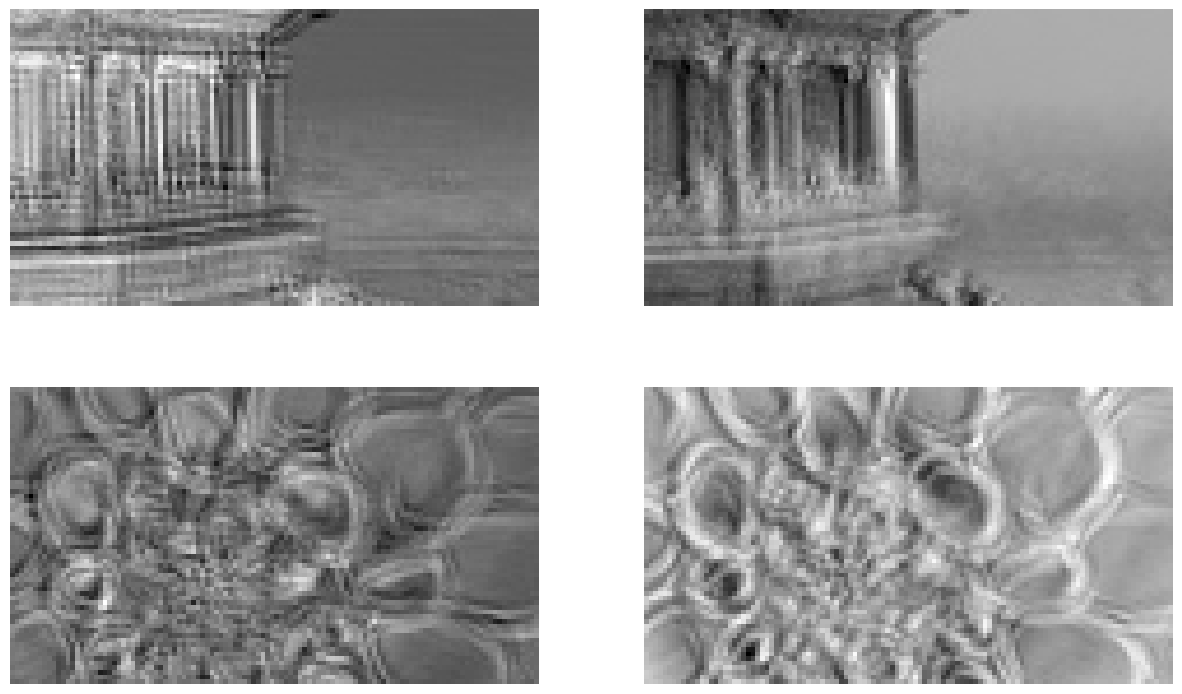

In [7]:
_fmaps = fmaps.cpu().detach().numpy()
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(_fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Randomly generated filters typically act like edge detectors. This is nice because it's useful for image processing, and that's the type of filters a convolutional layer usually starts with.
During training, it'll learn improved filters to recognize useful patterns for the task.

In [8]:
# 2D Max pooling layer with a 2x2 kernel size
# You can do average pooling by using `AvgPool2D` instead.
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [9]:
class DepthPool(keras.layers.Layer):
    """
    Depthwise pooling layer.

    Reshapes inputs to split channels into groups of desired size (pool_size).
    Then applies max pooling across each group.
    Assumes stride = pool size.
    """
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = inputs.shape
        n_channels = shape[-1]
        n_channel_groups = n_channels // self.pool_size
        new_shape = shape[:-1] + (n_channel_groups, self.pool_size)
        return inputs.view(*new_shape).max(dim=-1)[0]

In [10]:
fmaps = np.random.rand(2, 70, 120, 60)

with torch.no_grad():
    output = torch.nn.functional.max_pool2d(torch.tensor(fmaps), kernel_size=(1, 3), stride=(1, 3), padding=0)

output.shape

torch.Size([2, 70, 120, 20])

In [11]:
np.allclose(DepthPool(pool_size=3).forward(torch.tensor(fmaps)), output)

True

In [12]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [13]:
global_avg_pool(images)

tensor([[0.6434, 0.5972, 0.5825],
        [0.7631, 0.2601, 0.1085]], device='cuda:0')

## MNIST

In [14]:
mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test, axis=-1).astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [15]:
from functools import partial

# Define 'partial' function for the default convolutional layer
DefaultConv2D = partial(
    keras.layers.Conv2D, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"
)

# Create Sequential model
model = keras.Sequential(
    [
        # Images are 28x28 pixels, with 1 color channel (grayscale).
        keras.layers.Input(shape=[28, 28, 1]),
        # 64 filters (7x7 kernel), which is fairly large.
        # Uses default stride of 1 (input imgs are not very large).
        DefaultConv2D(filters=64, kernel_size=7),
        # Reduces size of feature maps by 2x due to default pool size of 2.
        keras.layers.MaxPool2D(),
        # Repeat, but with: 128 filters (3x3 kernel)
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        keras.layers.MaxPool2D(),
        # Repeat, but with: 256 filters (3x3 kernel)
        # Notice the number of filters double as we go deeper into the network.
        # It makes sense to grow, since the number of low-level features is rather low, but there are many ways to combine them into higher-level features.
        # It's common to double the number of filters after each pooling layer, as the pooling layer divides each spatial dimension by a factor of 2, we can double the number of feature maps without fear of exploding parameters, memory usage, or computational load.
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        keras.layers.MaxPool2D(),
        # Now for the fully connected network.
        # Two hidden dense layers & a dense output layer.
        # We use softmax for the output layer, since this is a multiclass classification task.
        # We also use dropout to reduce overfitting.
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=10, activation="softmax"),
    ]
)

In [17]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.8338 - loss: 0.4867 - val_accuracy: 0.8812 - val_loss: 0.3263
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.8762 - loss: 0.3670 - val_accuracy: 0.8968 - val_loss: 0.2829
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.8938 - loss: 0.3127 - val_accuracy: 0.8972 - val_loss: 0.2690
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.9036 - loss: 0.2826 - val_accuracy: 0.9038 - val_loss: 0.2622
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9065 - loss: 0.2730 - val_accuracy: 0.8976 - val_loss: 0.2830
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9104 - loss: 0.2561 - val_accuracy: 0.9092 - val_loss: 0.2549
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9192 - loss: 0.2384 - val_accuracy: 0.9114 - val_loss: 0.2681
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9204 -

# Model Architectures

## GoogLeNet (Inception v1)

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, GlobalAvgPool2D, Dense, Dropout, concatenate, Layer
import torch.nn.functional as F


def inception_module(input, f1s1, f3x3_reduce, f3x3, f5x5_reduce, f5x5, fpool):
    # paths from left -> right
    # branch1: conv 1x1, stride=1, padding=same
    # branch2: conv 1x1, stride=1, padding=same -> conv 3x3, stride=1, padding=same
    # branch3: conv 1x1, stride=1, padding=same -> conv 5x5, stride=1, padding=same
    # branch4: max pool 3x3, stride=1, padding=same -> conv 1x1, stride=1, padding=same
    branch1 = Conv2D(filters=f1s1, kernel_size=(1, 1), padding="same", strides=1, activation="relu")(input)

    branch2 = Conv2D(filters=f3x3_reduce, kernel_size=(1, 1), padding="same", strides=1, activation="relu")(input)
    branch2 = Conv2D(filters=f3x3, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(branch2)

    branch3 = Conv2D(filters=f5x5_reduce, kernel_size=(1, 1), padding="same", strides=1, activation="relu")(input)
    branch3 = Conv2D(filters=f5x5, kernel_size=(5, 5), padding="same", strides=1, activation="relu")(branch3)

    branch4 = MaxPool2D(pool_size=(3, 3), strides=1, padding="same")(input)
    branch4 = Conv2D(filters=fpool, kernel_size=(1, 1), padding="same", strides=1, activation="relu")(branch4)

    output = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output


class LocalResponseNormalization(Layer):
    def __init__(self, size=5, alpha=1e-4, beta=0.75, k=2.0, **kwargs):
        super(LocalResponseNormalization, self).__init__(**kwargs)
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def call(self, inputs):
        square = torch.pow(inputs, 2)
        scale = self.k + self.alpha * F.avg_pool2d(square, self.size, stride=1, padding=self.size // 2)
        scale = torch.pow(scale, self.beta)
        return inputs / scale


def GoogLeNet():
    input = Input(shape=(224, 224, 3))

    x = Conv2D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu")(input)
    x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    x = LocalResponseNormalization()(x)
    x = Conv2D(filters=64, kernel_size=1, padding="same", strides=1, activation="relu")(x)
    x = Conv2D(filters=192, kernel_size=3, padding="same", strides=1, activation="relu")(x)
    x = LocalResponseNormalization()(x)
    x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)

    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = GlobalAvgPool2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(units=1000, activation="softmax")(x)

    model = Model(inputs=input, outputs=x, name="GoogLeNet")
    return model


model = GoogLeNet()
model.summary()

Model: "GoogLeNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 56, 56,    │          0 │ conv2d_118[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ local_response_nor… │ (None, 56, 56,    │          0 │ max_pooling2d_28… │
│ (LocalResponseNorm… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 56, 56,    │      4,160 │ local_response_n… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 56, 56,    │    110,784 │ conv2d_119[0][0]  │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ local_response_nor… │ (None, 56, 56,    │          0 │ conv2d_120[0][0]  │
│ (LocalResponseNorm… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 28, 28,    │          0 │ local_response_n… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 28, 28,    │     18,528 │ max_pooling2d_29… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 28, 28,    │      3,088 │ max_pooling2d_29… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 28, 28,    │          0 │ max_pooling2d_29… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 28, 28,    │     12,352 │ max_pooling2d_29… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 28, 28,    │    110,720 │ conv2d_122[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 28, 28,    │     12,832 │ conv2d_124[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 28, 28,    │      6,176 │ max_pooling2d_30… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 28, 28,    │          0 │ conv2d_121[0][0], │
│ (Concatenate)       │ 256)              │            │ conv2d_123[0][0], │
│                     │                   │            │ conv2d_125[0][0], │
│                     │                   │            │ conv2d_126[0][0]

 Total params: 6,998,552 (26.70 MB)

 Trainable params: 6,998,552 (26.70 MB)

 Non-trainable params: 0 (0.00 B)

# Building ResNet-34

In [4]:
from functools import partial

DefaultConv2D = partial(
    keras.layers.Conv2D, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal", use_bias=False
)


class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization(),
        ]
        # Need skip layers for the shortcut connection if strides > 1
        # as we'll be adding the input to the output of the main layers
        # and the shape of the input will be different from the output without this
        self.skip_layers = (
            [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization(),
            ]
            if strides > 1
            else []
        )

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

model = keras.Sequential([
    keras.layers.Input(shape=[224, 224, 3]),
    DefaultConv2D(64, kernel_size=7, strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])

prev_filters = 64
# First 3 RUs have 64 filters, next 4 have 128, etc...
# We set stride=1 when number of filters is the same as in the previous RU, otherwise we set it to 2.
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)